# Email spam classification

   - The dataset contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      

### (a) Print the number of ham and spam emails 
In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it?

In [1]:
import glob

ham_filenames = glob.glob('./email-data/ham/*.txt')
spam_filenames = glob.glob('./email-data/spam/*.txt')

ham_num = len(ham_filenames)
spam_num = len(spam_filenames)

print('number of ham: ', ham_num)
print('number of spam: ', spam_num)

number of ham:  1500
number of spam:  3671


It is a imbalanced dataset. It can be problematic which would affect the model's performance.
It is better to use F1 score, confusion matrices or other methods to measure the performance of the model rather than accuracy.


### (b) Construct the documents

   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [4]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [5]:
# your code here
emails = []

for file_name in ham_filenames:
    emails.append(makeWordList(file_name))

for file_name in spam_filenames:
    emails.append(makeWordList(file_name))

In [6]:
import numpy as np

spam_labels = [1 for i in range(spam_num)]
ham_labels = [0 for i in range(ham_num)]
email_labels = ham_labels + spam_labels
y = np.array(email_labels)
len(email_labels)

5171

### (c) Construct the document matrix `X` as a matrix of word frequencies
   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=50,stop_words="english",max_df=0.8)
X = vectorizer.fit_transform(emails)
vocabulary_size = len(vectorizer.get_feature_names())
print(vocabulary_size)

1680


### (d) k-NN, SVM, random forest: Hyperparameter selection

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - SVM: (SVC) Select `C` from a range of your choice, use any kernel that performs well.
   - Random forest: Select `n_estimators` **and** `max_depth` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_C`, `best_n_estimators`, and `best_max_depth` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [8]:
from sklearn import svm
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
import warnings 
warnings.filterwarnings("ignore") 

num_folds = 5
k_fold = KFold(num_folds)
indices = range(len(emails))

def hyperparameter_selection(model, hyperparameter_settings):
   
    best_hyperparam_setting = None
    best_cross_val_score = -np.inf  # assumes that a higher score is better
    for hyperparameter in hyperparameter_settings:
        fold_scores = []
        # your code to train and score the training data here
        for train_indices, val_indices in k_fold.split(indices):
            if model =='knn':
                classifier = KNeighborsClassifier(n_neighbors=hyperparameter)
            elif model =='svm':
                classifier = SVC(C=hyperparameter)
            elif model == 'rf':
                num_trees, max_depth = hyperparameter
                classifier = RandomForestClassifier(n_estimators=num_trees,
                                            max_depth=max_depth,
                                            random_state=0)
            classifier.fit(X[train_indices],
                           y[train_indices])
            predicted_val_labels = classifier.predict(X[val_indices])
            score = f1_score(y[val_indices], predicted_val_labels, average='weighted')
            fold_scores.append(score)

        cross_val_score = np.mean(fold_scores)
        print('hyperparameter = ', hyperparameter, ' ', cross_val_score)
        if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
            best_cross_val_score = cross_val_score
            best_hyperparam_setting = hyperparameter
            
    print('Best hyperparameter setting:', best_hyperparam_setting)
    return best_hyperparam_setting

In [9]:
# KNN
hyperparameter_settings_knn = [k for k in range(2, 12)]
best_k = hyperparameter_selection('knn', hyperparameter_settings_knn)

hyperparameter =  2   0.9296795735512214
hyperparameter =  3   0.9369790471526201
hyperparameter =  4   0.9251695988388565
hyperparameter =  5   0.9117659336830704
hyperparameter =  6   0.9150940499281814
hyperparameter =  7   0.8990806340546393
hyperparameter =  8   0.9021406171359443
hyperparameter =  9   0.8912059431293173
hyperparameter =  10   0.8946710696326241
hyperparameter =  11   0.8849165576324985
Best hyperparameter setting: 3


In [10]:
# SVM
hyperparameter_settings_svm = [0.001, 0.01, 0.1, 1, 10, 50, 100, 1000]
best_C = hyperparameter_selection('svm', hyperparameter_settings_svm)

hyperparameter =  0.001   0.6781322737468793
hyperparameter =  0.01   0.6781322737468793
hyperparameter =  0.1   0.7917959815026101
hyperparameter =  1   0.906839173827748
hyperparameter =  10   0.9720703668813722
hyperparameter =  50   0.9855609280130853
hyperparameter =  100   0.9857816531393448
hyperparameter =  1000   0.9837546520507592
Best hyperparameter setting: 100


In [11]:
# Random Forest
hyperparameter_settings_rf = [(num_trees, max_depth)
                              for num_trees in [50, 100, 150, 200, 250]
                              for max_depth in [3, 4, 5, 6, None]]
best_n_estimators, best_max_depth = hyperparameter_selection(
    'rf', hyperparameter_settings_rf)

hyperparameter =  (50, 3)   0.8338273998448844
hyperparameter =  (50, 4)   0.8440784894217362
hyperparameter =  (50, 5)   0.8596099665123715
hyperparameter =  (50, 6)   0.8750856093115992
hyperparameter =  (50, None)   0.9839366917636699
hyperparameter =  (100, 3)   0.8268838056411905
hyperparameter =  (100, 4)   0.8423409610751049
hyperparameter =  (100, 5)   0.8554153836545938
hyperparameter =  (100, 6)   0.8701648177924417
hyperparameter =  (100, None)   0.9847289444903604
hyperparameter =  (150, 3)   0.8180445818701042
hyperparameter =  (150, 4)   0.8404695177581634
hyperparameter =  (150, 5)   0.8554356188065413
hyperparameter =  (150, 6)   0.8684421840995249
hyperparameter =  (150, None)   0.9854181767951433
hyperparameter =  (200, 3)   0.819774883607154
hyperparameter =  (200, 4)   0.8410645070274505
hyperparameter =  (200, 5)   0.8558439481330199
hyperparameter =  (200, 6)   0.8680620332640505
hyperparameter =  (200, None)   0.9852967216327093
hyperparameter =  (250, 3)   0.819

### (e) Classifier testing: Precision-Recall and ROC curves [20 points]

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the training data.
   - Use test emails to in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 3 ROC curves, one for each classifier.
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 3 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

In [12]:
test_filenames = glob.glob('./email-data/testing/*.txt')
test_emails = []
test_labels = []
for file_name in test_filenames:
    if 'spam' in file_name:
        test_labels.append(1)
    elif 'ham' in file_name:
        test_labels.append(0)
    test_emails.append(makeWordList(file_name))

In [13]:
X_test = vectorizer.transform(test_emails)
X_test.shape

(100, 1680)

My approach to deal with the words in test data but not in train data is ignoring them. Since the occurrences of these words in train data which is larger than test data are zero, these words are not so important in the classification model. 

In [14]:
y_test = np.array(test_labels)
y_test.shape

(100,)

In [15]:
# Classification with best hyperparameters
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# knn
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X, y)
pred_knn = knn.predict(X_test)
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_test, pred_knn)
auc_knn = np.trapz(tpr_knn, fpr_knn)
precision_knn, recall_knn, _knn = precision_recall_curve(y_test, pred_knn)
avg_precision_knn = np.mean(precision_knn)

# SVM
svm = SVC(C=best_C)
svm.fit(X, y)
pred_svm = svm.predict(X_test)
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, pred_svm)
auc_svm = np.trapz(tpr_svm, fpr_svm)
precision_svm, recall_svm, _svm = precision_recall_curve(y_test, pred_svm)
avg_precision_svm = np.mean(precision_svm)

# RF
rf = RandomForestClassifier(
    n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=0)
rf.fit(X, y)
pred_rf = rf.predict(X_test)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, pred_rf)
auc_rf = np.trapz(tpr_rf, fpr_rf)
precision_rf, recall_rf, _rf = precision_recall_curve(y_test, pred_rf)
avg_precision_rf = np.mean(precision_rf)

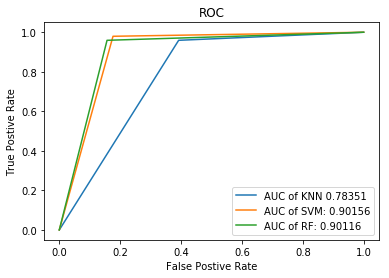

In [16]:
# plot for ROC
plt.plot(fpr_knn, tpr_knn)
plt.plot(fpr_svm, tpr_svm)
plt.plot(fpr_rf, tpr_rf)
ROC_labels = ['AUC of KNN {0:0.5f}'.format(auc_knn), 'AUC of SVM: {0:0.5f}'.format(
    auc_svm), 'AUC of RF: {0:0.5f}'.format(auc_rf)]
plt.legend(labels=ROC_labels)
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('ROC')
plt.show()

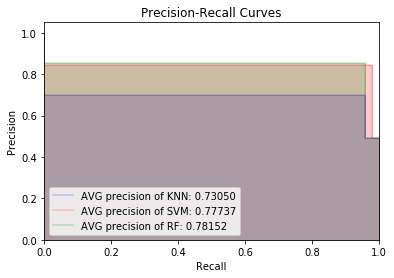

In [17]:
# precision_recall_curve
from sklearn.utils.fixes import signature

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.step(recall_knn, precision_knn, color='b', alpha=0.2,where='post')
plt.fill_between(recall_knn, precision_knn, alpha=0.2, color='b', **step_kwargs)

plt.step(recall_svm, precision_svm, color='r', alpha=0.2,where='post')
plt.fill_between(recall_svm, precision_svm, alpha=0.2, color='r', **step_kwargs)

plt.step(recall_rf, precision_rf, color='g', alpha=0.2,where='post')
plt.fill_between(recall_rf, precision_rf, alpha=0.2, color='g', **step_kwargs)

Precision_labels = ['AVG precision of KNN: {0:0.5f}'.format(avg_precision_knn), 'AVG precision of SVM: {0:0.5f}'.format(
    avg_precision_svm), 'AVG precision of RF: {0:0.5f}'.format(avg_precision_rf)]
plt.legend(labels=Precision_labels)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curves')
plt.show()

It is more proper to use ROC. The recall in PRC is as same as the TPR in ROC. The FPR is more important and more straigtforward than precision in this case, since it is bad if we classify ham emails(negative) as spam emails(positive). 